# Import Library

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn import mixture
from sklearn import preprocessing
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

# Data Preprocess

### Utility Functions

In [4]:
def read_data(folder, step):
    """
    read single step particle property file
    """
    # define file path and read in the file as dataframe
    file_path = "../data/50mph/" + str(folder) + "/" + str(folder) + str(step)
    data = pd.read_csv(file_path)
    
    return data
    
def match_partnum(df1, df2):
    """
    ensure dataframe df1 and df2 have same part_num
    """
    # find part_num differences between two dataframes
    diff1 = list(set(df1["part_num"]) - set(df2["part_num"]))
    diff2 = list(set(df2["part_num"]) - set(df1["part_num"]))
    
    # drop rows containing part_num that only exist in one of the dataframes
    del_row_idx1 = []
    del_row_idx2 = []
    for i in range(len(diff1)):
        del_row_idx1.append(int(np.where(df1["part_num"] == diff1[i])[0]))
    df1 = df1.drop(del_row_idx1, axis=0)

    for i in range(len(diff2)):
        del_row_idx2.append(int(np.where(df2["part_num"] == diff2[i])[0]))
    df2 = df2.drop(del_row_idx2, axis=0)

    # reset dataframe index to range(part_num), otherwise there is a mismatch of index between 
    # df1 and df2 since index won't be reassigned when droping rows. Such mismatch leads
    # NaN values when calculating particle movement
    df1 = df1.set_index(pd.Index(range(len(df1["part_num"]))))
    df2 = df2.set_index(pd.Index(range(len(df2["part_num"]))))
    
    return df1, df2

def util_winsorization(df):
    """helper function to perform winsorization"""
    # find the threshold for winsorization
    p = 0.95
    quantile_value = np.quantile(df, p)
    
    # apply winsorizaiton on the given column df
    df = df.apply(lambda x: x if x < quantile_value else quantile_value)
    
    return df

def preprocess(df):
    """
    collections of functions to preprocess dataframe before clustering analysis
    """
    # change movement into absolute values
    df.iloc[:,4:7] = np.abs(df.iloc[:,4:7])

    # take natural logarithm for movement columns, min_value added to fix extreme value cases
    min_value = 1e-5
    df.iloc[:,4:7] = np.log(df.iloc[:,4:7] + min_value)
    
    # winsorization is not suitable for movement only clustering, it actually makes the clustering results worse
    # df.iloc[:,4:7] = df.iloc[:,4:7].apply(util_winsorization, axis = 0)
    
    # standardization 
    tmp = pd.DataFrame(preprocessing.scale(df.iloc[:,4:7]))
    tmp = tmp.set_index(pd.Index(range(len(df["part_num"]))))
    tmp.columns = df.columns[4:7]
    df.iloc[:,4:7] = tmp
    
    return df

def cross_section(df, x_range=None, y_range=None, z_range=None):
    """choose part_num within the given x, y, z range"""
    
    if x_range != None:
        df = df.loc[(df['x'] >= x_range[0]) & (df['x'] <= x_range[1])]
    if y_range != None:
        df = df.loc[(df['y'] >= y_range[0]) & (df['y'] <= y_range[1])]
    if z_range != None:
        df = df.loc[(df['z'] >= z_range[0]) & (df['z'] <= z_range[1])]
    
    return df["part_num"]
    

# Clustering
### Center Binding

In [5]:
# set folder name and file name
folder_init, folder_final = "cb_d9out", "cb_d16out"
step_init, step_final = "_Step1.csv", "_Step303.csv"

# read initial state file and final state file
init_state = read_data(folder_init, step_init)
final_state = read_data(folder_final, step_final)

# remove particles not exist in both files 
init_state, final_state = match_partnum(init_state, final_state)

# calculate particle movement in x, y, z directions
part_movement = []
part_movement = final_state.iloc[:,2:5] - init_state.iloc[:,2:5]

# finalize particle movement dataframe
part_movement = pd.concat([final_state["part_num"].astype(int), final_state.iloc[:,2:5],
                           part_movement], axis=1)
part_movement.index.name = ""
part_movement.columns = ['part_num', 'x', 'y', 'z', 'movement_x', 'movement_y', 'movement_z']

# preprocess dataframe
part_movement = preprocess(part_movement)


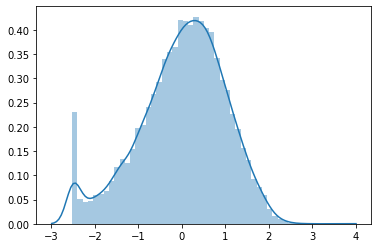

In [6]:
%matplotlib inline

# get a intuition of data distributions
sns.distplot(pd.DataFrame(part_movement["movement_z"]))


In [8]:
import visualization_util as vs
# unsuperised kmeans clustering
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(part_movement.iloc[:,4:7])

# check clustering distribution
print(Counter(kmeans.labels_))

# saving labels to csv file
label = pd.DataFrame({'part_num':part_movement["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_movement_cb.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_movement_cb.csv', 'CenterBinding.v3d','library.vlb')

Counter({1: 3396, 3: 3249, 4: 2253, 0: 1468, 2: 1060})


In [9]:
# visualization ballast cross section
# print(max(part_movement['x']), min(part_movement['x']))
# print(max(part_movement['y']), min(part_movement['y']))
# print(max(part_movement['z']), min(part_movement['z']))

y_range = [0.85, 1.05]
part_num = cross_section(part_movement, y_range=y_range)
label = [label for row_idx, label in enumerate(kmeans.labels_) if row_idx in part_num.index.values]

save = pd.DataFrame({'part_num':part_num,'label':label})
save.to_csv('../output/labels_movement_cross_cb.csv',header=True, index=False)
vs.plot('../output/labels_movement_cross_cb.csv', 'CenterBinding.v3d','library.vlb')

### Full Support

In [11]:
# set folder name and file name
folder_init, folder_final = "fs_d7out", "fs_d14out"
step_init, step_final = "_Step1.csv", "_Step303.csv"

# read initial state file and final state file
init_state = read_data(folder_init, step_init)
final_state = read_data(folder_final, step_final)

# remove particles not exist in both files 
init_state, final_state = match_partnum(init_state, final_state)

# print(list(set(init_state["part_num"]) - set(final_state["part_num"])))
# calculate particle movement in x, y, z directions
part_movement = []
part_movement = final_state.iloc[:,2:5] - init_state.iloc[:,2:5]
# finalize particle movement dataframe

part_movement = pd.concat([final_state["part_num"].astype(int), final_state.iloc[:,2:5],
                           part_movement], axis=1)
part_movement.index.name = ""
part_movement.columns = ['part_num', 'x', 'y', 'z', 'movement_x', 'movement_y', 'movement_z']

# preprocess dataframe
# print(part_movement.iloc[:,:7])
part_movement = preprocess(part_movement)


In [12]:
# unsuperised kmeans clustering
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(part_movement.iloc[:,4:7])

# check clustering distribution
print(Counter(kmeans.labels_))

# saving labels to csv file
label = pd.DataFrame({'part_num':part_movement["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_movement_fs.csv',header=True, index=False)

# visualization
vs.plot('../output/labels_movement_fs.csv', 'FullSup.v3d','library.vlb')

Counter({0: 3740, 2: 2472, 4: 1633, 1: 1626, 3: 1148})


In [19]:
# visualization ballast cross section
y_range = [0.85, 1.05]
part_num = cross_section(part_movement, y_range=y_range)
label = [label for row_idx, label in enumerate(kmeans.labels_) if row_idx in part_num.index.values]

save = pd.DataFrame({'part_num':part_num,'label':label})
save.to_csv('../output/labels_movement_cross_fs.csv',header=True, index=False)
vs.plot('../output/labels_movement_cross_fs.csv', 'FullSup.v3d','library.vlb')

### Lack of Center Support

In [16]:
# set folder name and file name
folder_init, folder_final = "locs_d9out", "locs_d16out"
step_init, step_final = "_Step1.csv", "_Step303.csv"

# read initial state file and final state file
init_state = read_data(folder_init, step_init)
final_state = read_data(folder_final, step_final)

# remove particles not exist in both files 
init_state, final_state = match_partnum(init_state, final_state)

# print(list(set(init_state["part_num"]) - set(final_state["part_num"])))
# calculate particle movement in x, y, z directions
part_movement = []
part_movement = final_state.iloc[:,2:5] - init_state.iloc[:,2:5]
# finalize particle movement dataframe

part_movement = pd.concat([final_state["part_num"].astype(int), final_state.iloc[:,2:5],
                           part_movement], axis=1)
part_movement.index.name = ""
part_movement.columns = ['part_num', 'x', 'y', 'z', 'movement_x', 'movement_y', 'movement_z']

# preprocess dataframe
# print(part_movement.iloc[:,:7])
part_movement = preprocess(part_movement)


In [17]:
# unsuperised kmeans clustering
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(part_movement.iloc[:,4:7])
print(Counter(kmeans.labels_))
label = pd.DataFrame({'part_num':part_movement["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_movement_locs.csv',header=True, index=False)

vs.plot('../output/labels_movement_locs.csv', 'LackofCenterSup.v3d','library.vlb')

Counter({1: 4352, 2: 2094, 0: 1842, 4: 1679, 3: 1438})


In [27]:
# visualization ballast cross section
y_range = [0.85, 1.05]
x_range = [1.5, 2.5]
part_num = cross_section(part_movement, x_range=x_range)
label = [label for row_idx, label in enumerate(kmeans.labels_) if row_idx in part_num.index.values]

save = pd.DataFrame({'part_num':part_num,'label':label})
save.to_csv('../output/labels_movement_cross_locs.csv',header=True, index=False)
vs.plot('../output/labels_movement_cross_locs.csv', 'LackofCenterSup.v3d','library.vlb')

### Lack of Rail Seat Support

In [28]:
# set folder name and file name
folder_init, folder_final = "lorss_d13out", "lorss_d20out"
step_init, step_final = "_Step1.csv", "_Step303.csv"

# read initial state file and final state file
init_state = read_data(folder_init, step_init)
final_state = read_data(folder_final, step_final)

# remove particles not exist in both files 
init_state, final_state = match_partnum(init_state, final_state)

# print(list(set(init_state["part_num"]) - set(final_state["part_num"])))
# calculate particle movement in x, y, z directions
part_movement = []
part_movement = final_state.iloc[:,2:5] - init_state.iloc[:,2:5]
# finalize particle movement dataframe

part_movement = pd.concat([final_state["part_num"].astype(int), final_state.iloc[:,2:5],
                           part_movement], axis=1)
part_movement.index.name = ""
part_movement.columns = ['part_num', 'x', 'y', 'z', 'movement_x', 'movement_y', 'movement_z']

# preprocess dataframe
# print(part_movement.iloc[:,:7])
part_movement = preprocess(part_movement)


In [29]:
# unsuperised kmeans clustering
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(part_movement.iloc[:,4:7])
print(Counter(kmeans.labels_))
label = pd.DataFrame({'part_num':part_movement["part_num"],'label':kmeans.labels_})
label.to_csv('../output/labels_movement_lorss.csv',header=True, index=False)
vs.plot('../output/labels_movement_lorss.csv', 'LackofRailSeatSup.v3d','library.vlb')

Counter({4: 3883, 2: 2787, 1: 2191, 0: 1673, 3: 1243})


In [32]:
# visualization ballast cross section
y_range = [0.85, 1.05]
part_num = cross_section(part_movement, y_range=y_range)
label = [label for row_idx, label in enumerate(kmeans.labels_) if row_idx in part_num.index.values]

save = pd.DataFrame({'part_num':part_num,'label':label})
save.to_csv('../output/labels_movement_cross_lorss.csv',header=True, index=False)
vs.plot('../output/labels_movement_cross_lorss.csv', 'LackofRailSeatSup.v3d','library.vlb')